In [806]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from random import random, choice
import numpy as np
import math
from scipy.spatial.distance import euclidean

# Simulating a bouncing ball

In [662]:
def will_bounce(initial_state, delta_t):
    x0, y0, v0x, v0y = initial_state[0], initial_state[1], initial_state[2], initial_state[3]
    #print x0, y0, v0x, v0y
    t_bounce_1 = (v0y + math.sqrt(v0y**2 + 2*9.81*y0) ) / 9.81
    t_bounce_2 = (v0y - math.sqrt(v0y**2 + 2*9.81*y0) ) / 9.81
    #print t_bounce_1, t_bounce_2
    t_bounce = max(t_bounce_1,t_bounce_2)
    
    if (delta_t > t_bounce):
        return True
    else:
        return False

def get_bounce_state(initial_state, delta_t):
    alpha = 0.8
    x0, y0, v0x, v0y = initial_state[0], initial_state[1], initial_state[2], initial_state[3]
    t_bounce_1 = (v0y + math.sqrt(v0y**2 + 2*9.81*y0) ) / 9.81
    t_bounce_2 = (v0y - math.sqrt(v0y**2 + 2*9.81*y0) ) / 9.81
    t_bounce = max(0,max(t_bounce_1,t_bounce_2))
    
    xb = v0x * t_bounce + x0
    #yb = -(1.0/2.0)*(t_bounce**2)*9.81 + v0y*t_bounce + y0
    yb = 0.0
    vbx = v0x
    vby = alpha*((-1)* (-(9.81)*t_bounce + v0y))
    return t_bounce, np.array([xb, yb, vbx, vby])
        

def update(state, delta_t):
    x0, y0, v0x, v0y = state[0], state[1], state[2], state[3]
    if will_bounce(state, delta_t):
        t_bounce, bounce_state = get_bounce_state(state, delta_t)
        xb, yb, vbx, vby = bounce_state

        t_left = delta_t - t_bounce
        x1 = vbx * t_left + xb
        y1 = -(1.0/2.0)*(t_left**2)*9.81 + vby*t_left + yb
        v1x = vbx
        v1y = -(9.81)*t_left + vby
        return np.array([x1, y1, v1x, v1y])
        
    else:
        x1 = v0x * delta_t + x0
        y1 = -(1.0/2.0)*(delta_t**2)*9.81 + v0y*delta_t + y0
        v1x = v0x
        v1y = -(9.81)*delta_t + v0y
        return np.array([x1, y1, v1x, v1y])

def generate_trajectory(state_0, delta_t, steps):
    trajectory_matrix = np.array([state_0])
    for i in range(steps):
        new_state = update(trajectory_matrix[i], delta_t)
        trajectory_matrix = np.vstack([trajectory_matrix, new_state])
    return trajectory_matrix

def distance_to_observation(state, observation):
    return euclidean(state[0:2],observation)

In [790]:
trajectory = generate_trajectory([1,8,0.8,1.4], 0.1, 1000)

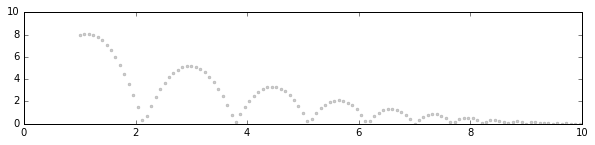

In [791]:
fig = plt.figure(figsize=(10,2))
ax = plt.axes()
ax.set_xlim(0,10)
ax.set_ylim(0,10)
ax.plot(trajectory[:,0],trajectory[:,1],'k.',alpha=0.2)

# The bootstrap filter

### One iteration of the bootstrap filter

What things could be happening ? How likely is each thing ? Then for each thing that could be happening, what would I expect to observe ? Then, "How likely is each thing given what I actually observed ?"

In [792]:
nb_particles = 1000
initial_measurement = np.array([1,8])
initial_speed = np.array([0.8,1.4])
initial_state = np.concatenate((initial_measurement,initial_speed))
hypothetical_balls = np.random.multivariate_normal(initial_measurement,[[.1, 0], [0, 0.1]],size=(nb_particles))
hypothetical_speeds = np.random.uniform(-2,2,size=(nb_particles,2))
hypothetical_weights = (1.0/nb_particles) * np.ones((nb_particles,1))
hypothetical_states = np.hstack([hypothetical_balls, hypothetical_speeds])


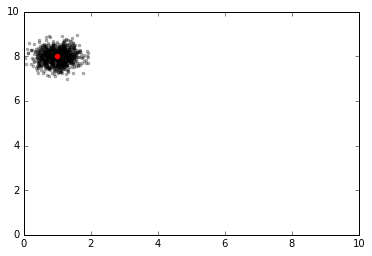

In [793]:
fig = plt.figure()
ax = plt.axes()
ax.set_xlim(0,10)
ax.set_ylim(0,10)
ax.plot(hypothetical_balls[:,0],hypothetical_balls[:,1],'k.',alpha=.3)
ax.plot(initial_measurement[0],initial_measurement[1],'ro')

In [794]:
next_state = update(initial_state,1)

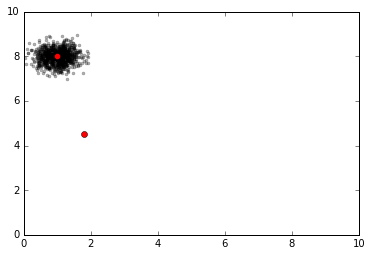

In [795]:
fig = plt.figure()
ax = plt.axes()
ax.set_xlim(0,10)
ax.set_ylim(0,10)
ax.plot(hypothetical_balls[:,0],hypothetical_balls[:,1],'k.',alpha=.3)
ax.plot(initial_measurement[0],initial_measurement[1],'ro')
ax.plot(next_state[0],next_state[1],'ro')

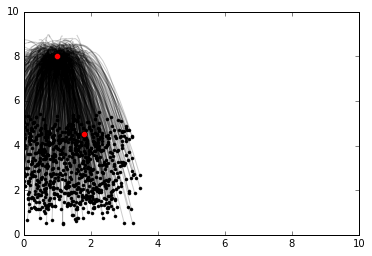

In [796]:
fig = plt.figure()
ax = plt.axes()
ax.set_xlim(0,10)
ax.set_ylim(0,10)
for i in range(hypothetical_states.shape[0]):
    trajectory = generate_trajectory(hypothetical_states[i], 0.1, 10)
    ax.plot(trajectory[:,0],trajectory[:,1],'k',alpha=0.2)
    ax.plot(trajectory[trajectory.shape[0]-1,0], trajectory[trajectory.shape[0]-1,1],'k.')
ax.plot(initial_measurement[0],initial_measurement[1],'ro')
ax.plot(next_state[0],next_state[1],'ro')

In [797]:
next_states = np.apply_along_axis(update, 1, hypothetical_states, 1)

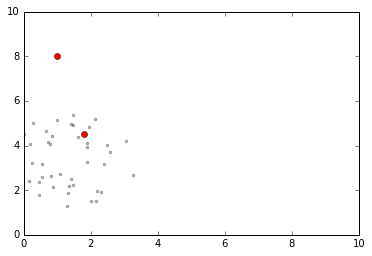

In [798]:
fig = plt.figure()
ax = plt.axes()
ax.set_xlim(0,10)
ax.set_ylim(0,10)
ax.plot(initial_measurement[0],initial_measurement[1],'ro')
ax.plot(next_state[0],next_state[1],'ro')
ax.plot(next_states[:50,0],next_states[:50,1],'k.',alpha=.3)

In [799]:
distances = np.apply_along_axis(distance_to_observation,1, next_states, next_state[0:2])
errors_probas = 1 - (distances - (np.min(distances))) / (np.max(distances) - np.min(distances))

next_states[np.where(errors_probas > .95)][:,0]

array([ 1.61520344,  2.02444562,  1.61054724,  1.99294499,  1.87987521,
        2.05250009,  1.65407311,  1.75249247,  1.53047438,  1.7701274 ,
        1.83040382,  1.86351579,  1.58676903,  1.8814413 ,  1.74916526,
        1.77978654,  1.85919942])

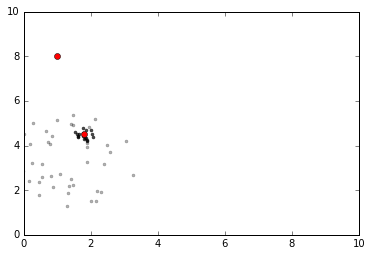

In [800]:
fig = plt.figure()
ax = plt.axes()
ax.set_xlim(0,10)
ax.set_ylim(0,10)
ax.plot(initial_measurement[0],initial_measurement[1],'ro')
ax.plot(next_states[:50,0],next_states[:50,1],'k.',alpha=.3)
ax.plot(next_states[np.where(errors_probas > 0.95)][:,0], next_states[np.where(errors_probas > 0.95)][:,1],'k.',alpha=.7)
ax.plot(next_state[0],next_state[1],'ro')

In [801]:
estimated_state = np.sum((next_states*(errors_probas/np.sum(errors_probas)).reshape(1000,1)),0)

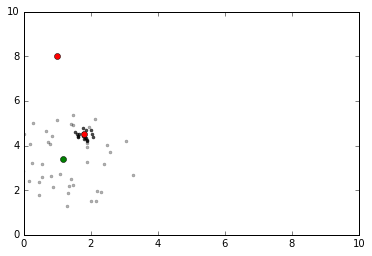

In [802]:
fig = plt.figure()
ax = plt.axes()
ax.set_xlim(0,10)
ax.set_ylim(0,10)
ax.plot(initial_measurement[0],initial_measurement[1],'ro')
ax.plot(next_states[:50,0],next_states[:50,1],'k.',alpha=.3)
ax.plot(next_states[np.where(errors_probas > 0.95)][:,0], next_states[np.where(errors_probas > 0.95)][:,1],'k.',alpha=.7)
ax.plot(next_state[0],next_state[1],'ro')
ax.plot(estimated_state[0],estimated_state[1],'go')

### Another iteration

In [803]:
next_next_state = update(next_state,1)
next_next_states = np.apply_along_axis(update, 1, next_states, 1)

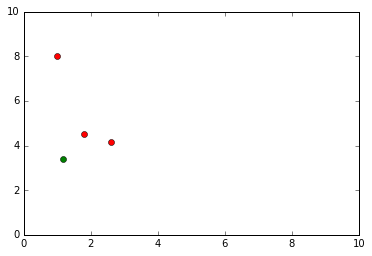

In [804]:
fig = plt.figure()
ax = plt.axes()
ax.set_xlim(0,10)
ax.set_ylim(0,10)
ax.plot(initial_measurement[0],initial_measurement[1],'ro')
ax.plot(next_state[0],next_state[1],'ro')
ax.plot(estimated_state[0],estimated_state[1],'go')
ax.plot(next_next_state[0],next_next_state[1],'ro')

In [805]:
next_next_states

array([[-0.69342342,  4.7847196 , -0.84021377,  2.21801418],
       [ 3.31478759,  5.25040324,  1.14088718,  2.15371444],
       [ 0.72453273,  4.44218837, -0.00806881,  4.14360074],
       ..., 
       [ 2.92680384,  4.59846476,  0.90103564,  2.61134452],
       [-2.75018143,  4.71958448, -1.94114082,  2.96929536],
       [-0.29607214,  4.71010912, -0.47237757,  1.93930089]])